In [1]:
# 匯入套件
import numpy as np
import pandas as pd
import itertools
import os
import gc
import logging

In [2]:
logger = logging.getLogger(__name__)

In [3]:
BASIC_FORMAT = "%(asctime)s-%(levelname)s-%(message)s"
chlr = logging.StreamHandler()
chlr.setFormatter(logging.Formatter(BASIC_FORMAT))
logger.setLevel('DEBUG')
logger.addHandler(chlr)

In [4]:
class data_restructuring:
    # 預先定義好的list，包含要預測的shop tag或目前要使用的columns
    SHOP_TAG_LIST = ['2', '6', '10', '12',
                    '13', '15', '18', '19',
                    '21', '22', '25', '26',
                    '36', '37', '39', '48']
    COL_LIST = ['dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt', 'domestic_offline_cnt',
        'domestic_online_cnt', 'overseas_offline_cnt', 'overseas_online_cnt',
        'domestic_offline_amt_pct', 'domestic_online_amt_pct',
        'overseas_offline_amt_pct', 'overseas_online_amt_pct', 'card_1_txn_cnt',
        'card_2_txn_cnt', 'card_3_txn_cnt', 'card_4_txn_cnt', 'card_5_txn_cnt',
        'card_6_txn_cnt', 'card_7_txn_cnt', 'card_8_txn_cnt', 'card_9_txn_cnt',
        'card_10_txn_cnt', 'card_11_txn_cnt', 'card_12_txn_cnt',
        'card_13_txn_cnt', 'card_14_txn_cnt', 'card_other_txn_cnt',
        'card_1_txn_amt_pct', 'card_2_txn_amt_pct', 'card_3_txn_amt_pct',
        'card_4_txn_amt_pct', 'card_5_txn_amt_pct', 'card_6_txn_amt_pct',
        'card_7_txn_amt_pct', 'card_8_txn_amt_pct', 'card_9_txn_amt_pct',
        'card_10_txn_amt_pct', 'card_11_txn_amt_pct', 'card_12_txn_amt_pct',
        'card_13_txn_amt_pct', 'card_14_txn_amt_pct', 'card_other_txn_amt_pct',
        'masts', 'educd', 'trdtp', 'naty', 'poscd', 'cuorg', 'slam',
        'gender_code', 'age', 'primary_card']
    def __init__(self, df_train_path, df_test_path, start_index, number):
        self.df_train_path = df_train_path
        if os.path.isfile(self.df_train_path) == False:
            raise Exception(f'The train data file path is wrong: {self.df_train_path}.')
        self.df_test_path = df_test_path
        if os.path.isfile(self.df_test_path) == False:
            raise Exception(f'The test data file path is wrong: {self.df_test_path}.')
        self.start_index = start_index
        self.number = number

    def _read_test_data_limited(self):
        logger.info('Start reading test data.')
        df_test = pd.read_csv(self.df_test_path)
        df_test = df_test[self.start_index: self.start_index+self.number].reset_index(drop=True)
        logger.info(f'Test data shape: {df_test.shape}')
        logger.info('Finish reading test data.')
        self._df_test = df_test

    def _read_train_data_by_chunk(self, chunksize=100000):
        logger.info('Start reading train data.')
        reader = pd.read_csv(self.df_train_path,
                            error_bad_lines=False, # 會自動忽略錯誤row
                            # header=None, # 看資料有無欄位名稱
                            iterator=True,
                            usecols=self.COL_LIST  #限縮要取的資料欄位
                            )
        loop = True
        chunks = []
        while loop:
            try:
                chunk = reader.get_chunk(chunksize)
                chunk = chunk[chunk.chid.isin(self._df_test.chid)]    #只取測試資料的前10,000 chid
                chunk = chunk[chunk.shop_tag.isin(self.SHOP_TAG_LIST)]   #指取要預測的消費類別
                chunks.append(chunk)
            except StopIteration:
                loop = False
                print("Iteration is stopped.")
        df = pd.concat(chunks,ignore_index=True)
        df.shop_tag = df.shop_tag.astype('int8')
        df = self._reduce_mem_usage(df=df, silent=False)
        logger.info('Finish reading train data.')
        return df

    @staticmethod
    def _reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
        """
        Iterates through all the columns of a dataframe and downcasts the data type
        to reduce memory usage. Can also factorize categorical columns to integer dtype.
        """
        def _downcast_numeric(series, allow_categorical=allow_categorical):
            """
            Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
            """
            if pd.api.types.is_sparse(series.dtype) is True:
                return series
            elif pd.api.types.is_numeric_dtype(series.dtype) is False:
                if pd.api.types.is_datetime64_any_dtype(series.dtype):
                    return series
                else:
                    if allow_categorical:
                        return series
                    else:
                        codes, uniques = series.factorize()
                        series = pd.Series(data=codes, index=series.index)
                        series = _downcast_numeric(series)
                        return series
            else:
                series = pd.to_numeric(series, downcast="integer")
            if pd.api.types.is_float_dtype(series.dtype):
                series = series.astype(float_dtype)
            return series

        if silent is False:
            start_mem = np.sum(df.memory_usage()) / 1024 ** 2
            print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
        if df.ndim == 1:
            df = _downcast_numeric(df)
        else:
            for col in df.columns:
                df.loc[:, col] = _downcast_numeric(df.loc[:,col])
        if silent is False:
            end_mem = np.sum(df.memory_usage()) / 1024 ** 2
            print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
            print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

        return df

    def _create_matrix_full(self, df_train):
        logger.info('Start creating training matrix.')
        indexlist = []
        x = itertools.product(df_train.dt.unique(), self._df_test.chid.unique(), self.SHOP_TAG_LIST)
        indexlist.append(np.array(list(x)))
        matrix = pd.DataFrame(
                data=np.concatenate(indexlist, axis=0),
                columns=["dt", "chid", "shop_tag"])
        matrix.dt = matrix.dt.astype('int8')
        matrix.chid = matrix.chid.astype('int32')
        matrix.shop_tag = matrix.shop_tag.astype('int8')
        matrix = matrix.merge(df_train, on=['dt', 'chid', 'shop_tag'], how='left')
        matrix.fillna(0, inplace=True)
        matrix = self._reduce_mem_usage(df=matrix, silent=False)
        self._matrix = matrix
        gc.collect()
        logger.info('Finish creating training matrix.')

    def execute(self):
        self._read_test_data_limited()
        df_train = self._read_train_data_by_chunk(chunksize=100000)
        self._create_matrix_full(df_train=df_train)

    @property
    def test_data(self):
        return self._df_test

    @property
    def matrix(self):
        return self._matrix

In [5]:
op = data_restructuring(df_train_path=r'D:\Gallon\Project\07_E_SUN_2021_Winter_AI\data\tbrain_cc_training_48tags_hash_final.csv',
                        df_test_path=r'D:\Gallon\Project\07_E_SUN_2021_Winter_AI\data\需預測的顧客名單及提交檔案範例.csv',
                        start_index=0,
                        number=1000)

In [6]:
op.execute()

2021-12-21 14:31:07,306-INFO-Start reading test data.
2021-12-21 14:31:07,745-INFO-Test data shape: (1000, 4)
2021-12-21 14:31:07,746-INFO-Finish reading test data.
2021-12-21 14:31:07,746-INFO-Start reading train data.


Iteration is stopped.
Memory usage of dataframe is 17.46 MB


2021-12-21 14:33:43,507-INFO-Finish reading train data.
2021-12-21 14:33:43,520-INFO-Start creating training matrix.


Memory usage after optimization is: 5.36 MB
Decreased by 69.3%
Memory usage of dataframe is 117.92 MB


2021-12-21 14:33:47,208-INFO-Finish creating training matrix.


Memory usage after optimization is: 47.61 MB
Decreased by 59.6%


In [2]:
# 定義function

# 此function為網路上的人撰寫，目的是降低DataFrame的大小
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

# 讀取資料，by chunk
def read_data_by_chunk(path, df_test, col_list, shop_tag_list, chunksize):
    reader = pd.read_csv(path,
                        error_bad_lines=False, # 會自動忽略錯誤row
                        # header=None, # 看資料有無欄位名稱
                        iterator=True,
                        usecols=col_list  #限縮要取的資料欄位
                        )
    loop = True
    chunks = []
    while loop:
        try:
            chunk = reader.get_chunk(chunksize)
            chunk = chunk[chunk.chid.isin(df_test.chid)]    #只取測試資料的前10,000 chid
            chunk = chunk[chunk.shop_tag.isin(shop_tag_list)]   #指取要預測的消費類別
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped.")
    df = pd.concat(chunks,ignore_index=True)
    return df


In [3]:
# 預先定義好的list，包含要預測的shop tag或目前要使用的columns
SHOP_TAG_LIST = ['2', '6', '10', '12',
                '13', '15', '18', '19',
                '21', '22', '25', '26',
                '36', '37', '39', '48']
COL_LIST = ['dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt', 'domestic_offline_cnt',
       'domestic_online_cnt', 'overseas_offline_cnt', 'overseas_online_cnt',
       'domestic_offline_amt_pct', 'domestic_online_amt_pct',
       'overseas_offline_amt_pct', 'overseas_online_amt_pct', 'card_1_txn_cnt',
       'card_2_txn_cnt', 'card_3_txn_cnt', 'card_4_txn_cnt', 'card_5_txn_cnt',
       'card_6_txn_cnt', 'card_7_txn_cnt', 'card_8_txn_cnt', 'card_9_txn_cnt',
       'card_10_txn_cnt', 'card_11_txn_cnt', 'card_12_txn_cnt',
       'card_13_txn_cnt', 'card_14_txn_cnt', 'card_other_txn_cnt',
       'card_1_txn_amt_pct', 'card_2_txn_amt_pct', 'card_3_txn_amt_pct',
       'card_4_txn_amt_pct', 'card_5_txn_amt_pct', 'card_6_txn_amt_pct',
       'card_7_txn_amt_pct', 'card_8_txn_amt_pct', 'card_9_txn_amt_pct',
       'card_10_txn_amt_pct', 'card_11_txn_amt_pct', 'card_12_txn_amt_pct',
       'card_13_txn_amt_pct', 'card_14_txn_amt_pct', 'card_other_txn_amt_pct',
       'masts', 'educd', 'trdtp', 'naty', 'poscd', 'cuorg', 'slam',
       'gender_code', 'age', 'primary_card']


#### 讀取測試資料，並篩選前10,000個chid

In [4]:
df_test = pd.read_csv(r'D:\Github\07_E_SUN_2021_Winter_AI\data\需預測的顧客名單及提交檔案範例.csv')
df_test = df_test[:10000].reset_index(drop=True)
df_test


,chid,top1,top2,top3
0,10128239,18,10,6
1,10077943,48,22,6
2,10277876,22,10,39
3,10364842,37,19,13
4,10392717,2,36,26
...,...,...,...,...
9995,10203858,25,22,37
9996,10008113,22,48,15
9997,10053154,37,39,12
9998,10252782,26,18,12


#### 匯入訓練資料，並根據篩選後的測試資料(df_test)選擇部分chid

In [5]:
df = read_data_by_chunk(path=r'D:\Github\07_E_SUN_2021_Winter_AI\data\tbrain_cc_training_48tags_hash_final.csv',
                    df_test=df_test,
                    col_list=COL_LIST,
                    shop_tag_list=SHOP_TAG_LIST,
                    chunksize=100000)


Iteration is stopped.


In [6]:
# 壓縮資料大小
df = reduce_mem_usage(df, silent=False)

Memory usage of dataframe is 177.49 MB
Memory usage after optimization is: 59.02 MB
Decreased by 66.7%


#### 建立以(dt, chid, shop_tag)為index 的資料

In [7]:
indexlist = []
x = itertools.product(df.dt.unique(), df_test.chid.unique(), SHOP_TAG_LIST)
indexlist.append(np.array(list(x)))
matrix = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["dt", "chid", "shop_tag"])

In [8]:
# 改變資料型態，壓縮資料大小
matrix.dt = matrix.dt.astype('int8')
matrix.chid = matrix.chid.astype('int32')
matrix.shop_tag = matrix.shop_tag.astype('int8')
df.shop_tag = df.shop_tag.astype('int8')

In [9]:
# 將訓練資料合併進我們建立的以(df, chid, shop_tag)為index 的資料
matrix = matrix.merge(df, on=['dt', 'chid', 'shop_tag'], how='left')
matrix.fillna(0, inplace=True)
matrix = reduce_mem_usage(matrix, silent=False)
gc.collect()

In [10]:
# 資料補0，並壓縮資料
matrix.fillna(0, inplace=True)
matrix = reduce_mem_usage(matrix, silent=False)

Memory usage of dataframe is 1164.55 MB
Memory usage after optimization is: 487.06 MB
Decreased by 58.2%


In [11]:
del df

In [12]:
gc.collect()

44

In [13]:
matrix.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3840000 entries, 0 to 3839999
Data columns (total 53 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   dt                        int8   
 1   chid                      int32  
 2   shop_tag                  int8   
 3   txn_cnt                   int16  
 4   txn_amt                   float32
 5   domestic_offline_cnt      int16  
 6   domestic_online_cnt       int8   
 7   overseas_offline_cnt      int8   
 8   overseas_online_cnt       int16  
 9   domestic_offline_amt_pct  float32
 10  domestic_online_amt_pct   float32
 11  overseas_offline_amt_pct  float32
 12  overseas_online_amt_pct   float32
 13  card_1_txn_cnt            int8   
 14  card_2_txn_cnt            int8   
 15  card_3_txn_cnt            int8   
 16  card_4_txn_cnt            int16  
 17  card_5_txn_cnt            int8   
 18  card_6_txn_cnt            int16  
 19  card_7_txn_cnt            int8   
 20  card_8_txn_cnt          

In [14]:
matrix.head()

,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,domestic_offline_amt_pct,...,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
0,1,10128239,2,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
1,1,10128239,6,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
2,1,10128239,10,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
3,1,10128239,12,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
4,1,10128239,13,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0.0,0,0,0


In [15]:
oldcols = matrix.columns

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [64]:
class FeatureEngineering:
    BASIC_FORMAT = "%(asctime)s-%(levelname)s-%(message)s"
    chlr = logging.StreamHandler()
    chlr.setFormatter(logging.Formatter(BASIC_FORMAT))
    logger.setLevel('DEBUG')
    logger.addHandler(chlr)

    def __init__(self, matrix):
        self.matrix = matrix
        self.oldcols = matrix.columns

    @staticmethod
    def _reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
        """
        Iterates through all the columns of a dataframe and downcasts the data type
        to reduce memory usage. Can also factorize categorical columns to integer dtype.
        """
        def _downcast_numeric(series, allow_categorical=allow_categorical):
            """
            Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
            """
            if pd.api.types.is_sparse(series.dtype) is True:
                return series
            elif pd.api.types.is_numeric_dtype(series.dtype) is False:
                if pd.api.types.is_datetime64_any_dtype(series.dtype):
                    return series
                else:
                    if allow_categorical:
                        return series
                    else:
                        codes, uniques = series.factorize()
                        series = pd.Series(data=codes, index=series.index)
                        series = _downcast_numeric(series)
                        return series
            else:
                series = pd.to_numeric(series, downcast="integer")
            if pd.api.types.is_float_dtype(series.dtype):
                series = series.astype(float_dtype)
            return series

        if silent is False:
            start_mem = np.sum(df.memory_usage()) / 1024 ** 2
            print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
        if df.ndim == 1:
            df = _downcast_numeric(df)
        else:
            for col in df.columns:
                df.loc[:, col] = _downcast_numeric(df.loc[:,col])
        if silent is False:
            end_mem = np.sum(df.memory_usage()) / 1024 ** 2
            print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
            print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

        return df

    def _shrink_mem_new_cols(self, allow_categorical=False):
        # Calls reduce_mem_usage on columns which have not yet been optimized
        if self.oldcols is not None:
            newcols = self.matrix.columns.difference(self.oldcols)
        else:
            newcols = self.matrix.columns
        self.matrix.loc[:,newcols] = self._reduce_mem_usage(self.matrix.loc[:,newcols], allow_categorical=allow_categorical)
        self.oldcols = self.matrix.columns  # This is used to track which columns have already been downcast

    @staticmethod
    def _list_if_not(s, dtype=str):
        # Puts a variable in a list if it is not already a list
        if type(s) not in (dtype, list):
            raise TypeError
        if (s != "") & (type(s) is not list):
            s = [s]
        return s

    # 每種類別的人均購買次數
    def _shop_tag_mean_txn(self):
        shop_tag_features = self.matrix.groupby(['shop_tag', 'chid'])['txn_cnt'].sum().reset_index()
        shop_tag_features = shop_tag_features.groupby(['shop_tag'])['txn_cnt'].mean().reset_index(name='shop_tag_mean_txn')
        self.matrix = self.matrix.merge(shop_tag_features, on=['shop_tag'])
    # 每種類別的人均購買頻次
    def _shop_tag_frequency_txn(self):
        shop_tag_features = self.matrix.query('txn_cnt > 0').groupby(['shop_tag', 'chid'])['dt'].nunique().reset_index(name='dt_cnt')
        shop_tag_features = shop_tag_features.groupby(['shop_tag'])['dt_cnt'].mean().reset_index(name='shop_tag_frequency_txn')
        self.matrix = self.matrix.merge(shop_tag_features, on=['shop_tag'])

    def _shop_tag_feature_engineering(self):
        self._shop_tag_mean_txn()
        self._shop_tag_frequency_txn()
        self._shrink_mem_new_cols(allow_categorical=False)

    def _cluster_feature(self, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
        matrix = self.matrix
        start_month = 12
        end_month = 24
        pt = matrix.query(f"dt>{start_month} & dt<={end_month}")
        if exclude is not None:
            pt = matrix[~matrix[clust_feature].isin(exclude)]
        pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
        pt = pt.transpose()
        pca = PCA(n_components=10)
        components = pca.fit_transform(pt)
        components = pd.DataFrame(components)
        # Plot PCA explained variance
        sns.set()
        features = list(range(pca.n_components_))
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(121)
    #     ax.bar(features, pca.explained_variance_ratio_, color="black")
        sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
        plt.title("Variance by PCA components")
        plt.xlabel("component")
        plt.ylabel("explained variance")
        plt.xticks(features)

        scorelist = []
        nrange = range(2, 10)
        for n in nrange:
            clusterer = AgglomerativeClustering(n_clusters=n)
            labels = clusterer.fit_predict(components)
            silscore = silhouette_score(pt, labels)
            scorelist.append(silscore)
        ax = fig.add_subplot(122)
        sns.lineplot(x=nrange, y=scorelist, ax=ax)
        plt.title("Clustering quality by number of clusters")
        plt.xlabel("n clusters")
        plt.ylabel("silhouette score")

        pca = PCA(n_components=n_components)
        components = pca.fit_transform(pt)
        components = pd.DataFrame(components)
        clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
        labels = clusterer.fit_predict(components)
        x = components[0]
        y = components[1]
        fig = plt.figure(figsize=(10, 4))
        ax = fig.add_subplot(111)
        sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
        plt.title("Items by cluster")
        plt.xlabel("component 1 score")
        plt.ylabel("component 2 score")
        for i, txt in enumerate(pt.index.to_list()):
            ax.annotate(str(txt), (x[i], y[i]))
        groups = {}
        for i, s in enumerate(pt.index):
            groups[s] = labels[i]
        return groups
    def _cluster_feature_engineering(self):
        shop_tag_group_dict = self._cluster_feature(
                                            'txn_amt',
                                            'shop_tag',
                                            'dt',
                                            n_components=2,
                                            n_clusters=4,
                                            aggfunc="mean",
                                            exclude =[])
        self.matrix['shop_tag_cluster'] = self.matrix['shop_tag'].map(shop_tag_group_dict)
        # 行業別根據不同類別的消費來分類
        chid_group_dict = self._cluster_feature(
                                        'txn_amt',
                                        'trdtp',
                                        'shop_tag',
                                        n_components=10,
                                        n_clusters=5,
                                        aggfunc="mean",
                                        exclude =[])
        self.matrix['trdtp_cluster'] = self.matrix['trdtp'].map(chid_group_dict)
        self._shrink_mem_new_cols(allow_categorical=False)

    def _add_pct_change(
        self,
        group_feats,
        target="txn_amt",
        aggfunc="mean",
        periods=1,
        lag=1,
        clip_value=None,
    ):
        periods = self._list_if_not(periods, int)
        group_feats = self._list_if_not(group_feats)
        group_feats_full = ["dt"] + group_feats
        dat = self.matrix.pivot_table(
            index=group_feats + ["dt"],
            values=target,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype("float32")
        for g in group_feats:
            firsts = self.matrix.groupby(g).dt.min().rename("firsts")
            dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
            dat.loc[dat.index.get_level_values("dt") < dat["firsts"], target] = float(
                "nan"
            )
            del dat["firsts"]
        for period in periods:
            feat_name = "_".join(
                group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
            )
            print(f"Adding feature {feat_name}")
            dat = (
                dat.groupby(group_feats)[target]
                .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
                .rename(feat_name)
            )
            if clip_value is not None:
                dat = dat.clip(lower=-clip_value, upper=clip_value)
        dat = dat.reset_index()
        dat["dt"] += lag
        self.matrix = self.matrix.merge(dat, on=["dt"] + group_feats, how="left")
        self.matrix[feat_name] = self._reduce_mem_usage(self.matrix[feat_name])

    def _pct_change_feature_engineeing(self):
        self._add_pct_change(["shop_tag"], "txn_amt", clip_value=3)
        self._add_pct_change(["shop_tag"], "txn_amt", lag=12, clip_value=3,)
        self._add_pct_change(["chid"], "txn_amt", clip_value=3)
        self._add_pct_change(["chid"], "txn_amt", lag=12, clip_value=3,)
        self._add_pct_change(["educd"], "txn_amt", clip_value=3)
        self._add_pct_change(["trdtp"], "txn_amt", clip_value=3)
        self._add_pct_change(["gender_code"], "txn_amt", clip_value=3)
        self._add_pct_change(["age"], "txn_amt", clip_value=3)
        self._shrink_mem_new_cols(allow_categorical=False)
        gc.collect()

    def _add_rolling_stats(
        self,
        features,
        window=12,
        kind="rolling",
        argfeat="txn_amt",
        aggfunc="mean",
        rolling_aggfunc="mean",
        dtype="float16",
        reshape_source=True,
        lag_offset=0,
    ):
        def rolling_stat(
            matrix,
            source,
            feats,
            feat_name,
            window=12,
            argfeat="txn_amt",
            aggfunc="mean",
            dtype=dtype,
            lag_offset=0,
        ):
            # Calculate a statistic on a windowed section of a source table,  grouping on specific features
            store = []
            for i in range(2 + lag_offset, 25 + lag_offset):
                if len(feats) > 0:
                    mes = (
                        source[source.dt.isin(
                            range(max([i - window, 0]), i))]
                        .groupby(feats)[argfeat]
                        .agg(aggfunc)
                        .astype(dtype)
                        .rename(feat_name)
                        .reset_index()
                    )
                else:
                    mes = {}
                    mes[feat_name] = (
                        source.loc[
                            source.dt.isin(
                                range(max([i - window, 0]), i)), argfeat
                        ]
                        .agg(aggfunc)
                        .astype(dtype)
                    )
                    mes = pd.DataFrame(data=mes, index=[i])
                mes["dt"] = i - lag_offset
                store.append(mes)
            store = pd.concat(store)
            self.matrix = matrix.merge(store, on=feats + ["dt"], how="left")

        """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
        treated as zeroes. Creating a pivot_table fills in the zeros."""
        if (reshape_source == True) or (kind == "ewm"):
            source = self.matrix.pivot_table(
                index=features + ["dt"],
                values=argfeat,
                aggfunc=aggfunc,
                fill_value=0,
                dropna=False,
            ).astype(dtype)
            for g in features:
                firsts = self.matrix.groupby(g).dt.min().rename("firsts")
                source = source.merge(
                    firsts, left_on=g, right_index=True, how="left")
                # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
                source.loc[
                    source.index.get_level_values(
                        "dt") < source["firsts"], argfeat
                ] = float("nan")
                del source["firsts"]
            source = source.reset_index()
        else:
            source = self.matrix

        if kind == "rolling":
            feat_name = (
                f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
            )
            print(f'Creating feature "{feat_name}"')
            rolling_stat(
                self.matrix,
                source,
                features,
                feat_name,
                window=window,
                argfeat=argfeat,
                aggfunc=rolling_aggfunc,
                dtype=dtype,
                lag_offset=lag_offset,
            )
        elif kind == "expanding":
            feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
            print(f'Creating feature "{feat_name}"')
            rolling_stat(
                self.matrix,
                source,
                features,
                feat_name,
                window=100,
                argfeat=argfeat,
                aggfunc=aggfunc,
                dtype=dtype,
                lag_offset=lag_offset,
            )
        elif kind == "ewm":
            feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
            print(f'Creating feature "{feat_name}"')
            # source[feat_name] = (
            #     source.groupby(features)[argfeat]
            #     .ewm(halflife=window, min_periods=1)
            #     .agg(rolling_aggfunc)
            #     .to_numpy(dtype=dtype)
            # )
            source[feat_name] = (
                    source.groupby(features)[argfeat].apply(lambda x: x.ewm(halflife=window, min_periods=1).mean()).to_numpy(dtype=dtype)
                )
            del source[argfeat]
            #         source = source.reset_index()
            source["dt"] += 1 - lag_offset
            self.matrix = self.matrix.merge(source, on=["dt"] + features, how="left")

    def _rolling_feature_engineering(self):
        # self._add_rolling_stats(
        #     ["chid", "shop_tag"],
        #     window=12,
        #     kind="rolling",
        #     reshape_source=False,
        # )
        # self._add_rolling_stats(
        #     ["chid", "shop_tag"],
        #     kind="expanding",
        #     reshape_source=False,
        # )
        self._add_rolling_stats(
            ["chid", "shop_tag"],
            window=1,
            kind="ewm",
        )

        # self._add_rolling_stats(
        #     ["age", "shop_tag"],
        #     window=12,
        #     kind="rolling",
        #     reshape_source=False,
        # )
        # self._add_rolling_stats(
        #     ["age", "shop_tag"],
        #     kind="expanding",
        #     reshape_source=False,
        # )
        # self._add_rolling_stats(
        #     ["age", "shop_tag"],
        #     window=1,
        #     kind="ewm",
        # )

        # self._add_rolling_stats(
        #     ["age", "gender_code", "shop_tag"],
        #     window=12,
        #     kind="rolling",
        #     reshape_source=False,
        # )
        # self._add_rolling_stats(
        #     ["age", "gender_code", "shop_tag"],
        #     kind="expanding",
        #     reshape_source=False,
        # )
        # self._add_rolling_stats(
        #     ["age", "gender_code", "shop_tag"],
        #     window=1,
        #     kind="ewm",
        # )
        self._shrink_mem_new_cols(allow_categorical=False)
        gc.collect()

    def execute(self):
        self._shop_tag_feature_engineering()
        self._cluster_feature_engineering()
        self._pct_change_feature_engineeing()
        self._rolling_feature_engineering()

In [9]:
op.matrix.shape

(384000, 53)

In [65]:
fe = FeatureEngineering(matrix=op.matrix)

In [66]:
fe._shop_tag_feature_engineering()

In [39]:
# fe._cluster_feature_engineering()

In [40]:
# fe._pct_change_feature_engineeing()

In [67]:
fe._rolling_feature_engineering()

Creating feature "chid_shop_tag_txn_amt_mean_ewm_hl_1"


In [45]:
fe.matrix.shape

(384000, 54)

## shop_tag

In [16]:
# 每種類別的人均購買次數
def shop_tag_mean_txn(matrix):
    shop_tag_features = matrix.groupby(['shop_tag', 'chid'])['txn_cnt'].sum().reset_index()
    shop_tag_features = shop_tag_features.groupby(['shop_tag'])['txn_cnt'].mean().reset_index(name='shop_tag_mean_txn')
    matrix = matrix.merge(shop_tag_features, on=['shop_tag'])
    return matrix
# 每種類別的人均購買頻次
def shop_tag_frequency_txn(matrix):
    shop_tag_features = matrix.query('txn_cnt > 0').groupby(['shop_tag', 'chid'])['dt'].nunique().reset_index(name='dt_cnt')
    shop_tag_features = shop_tag_features.groupby(['shop_tag'])['dt_cnt'].mean().reset_index(name='shop_tag_frequency_txn')
    matrix = matrix.merge(shop_tag_features, on=['shop_tag'])
    return matrix

matrix = shop_tag_mean_txn(matrix)
matrix = shop_tag_frequency_txn(matrix)
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [24]:
matrix.groupby(['shop_tag'])['shop_tag_frequency_txn'].mean()


shop_tag
2     5.805302
6     3.781222
10    8.028141
12    5.590472
13    5.950795
15    7.043478
18    3.221777
19    3.646626
21    2.703262
22    3.583520
25    3.717661
26    3.072751
36    9.310248
37    9.737577
39    3.014571
48    6.603077
Name: shop_tag_frequency_txn, dtype: float32

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 12
    end_month = 24
    pt = matrix.query(f"dt>{start_month} & dt<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups


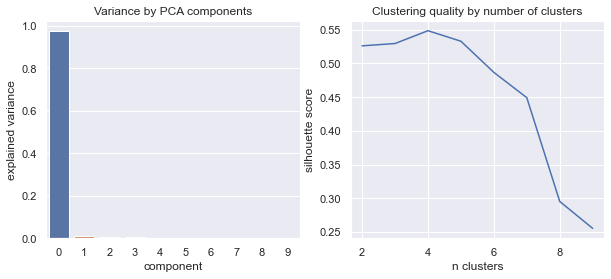

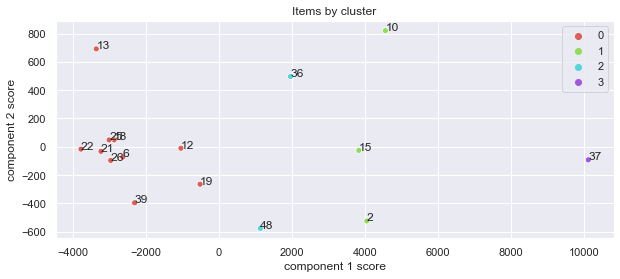

In [18]:
# 消費類別根據過去平均消費金額分類
shop_tag_group_dict = cluster_feature(matrix,
                                    'txn_amt',
                                    'shop_tag',
                                    'dt',
                                    n_components=2,
                                    n_clusters=4,
                                    aggfunc="mean",
                                    exclude =[])
matrix['shop_tag_cluster'] = matrix['shop_tag'].map(shop_tag_group_dict)

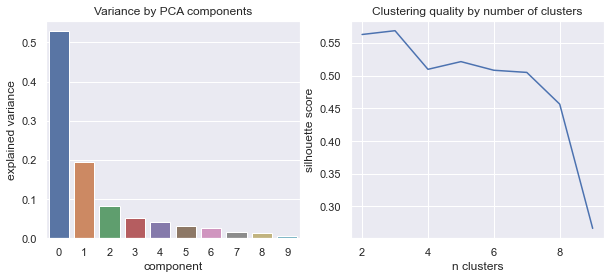

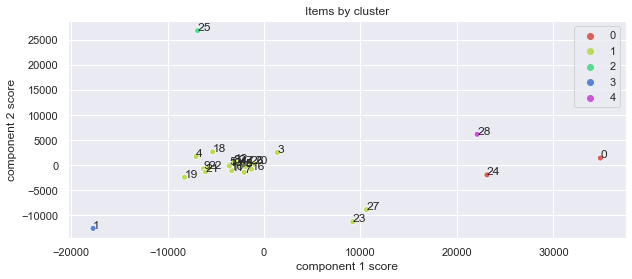

In [19]:
# 行業別根據不同類別的消費來分類
chid_group_dict = cluster_feature(matrix,
                                'txn_amt',
                                'trdtp',
                                'shop_tag',
                                n_components=10,
                                n_clusters=5,
                                aggfunc="mean",
                                exclude =[])
matrix['trdtp_cluster'] = matrix['trdtp'].map(shop_tag_group_dict)

In [20]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [27]:
def add_pct_change(
    matrix,
    group_feats,
    target="txn_amt",
    aggfunc="mean",
    periods=1,
    lag=1,
    clip_value=None,
):
    periods = list_if_not(periods, int)
    group_feats = list_if_not(group_feats)
    group_feats_full = ["dt"] + group_feats
    dat = matrix.pivot_table(
        index=group_feats + ["dt"],
        values=target,
        aggfunc=aggfunc,
        fill_value=0,
        dropna=False,
    ).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).dt.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("dt") < dat["firsts"], target] = float(
            "nan"
        )
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(
            group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat = (
            dat.groupby(group_feats)[target]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
            .rename(feat_name)
        )
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["dt"] += lag
    matrix = matrix.merge(dat, on=["dt"] + group_feats, how="left")
    matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
    return matrix

In [28]:
matrix = add_pct_change(matrix, ["shop_tag"], "txn_amt", clip_value=3)
matrix = add_pct_change(matrix, ["shop_tag"], "txn_amt", lag=12, clip_value=3,)
matrix = add_pct_change(matrix, ["chid"], "txn_amt", clip_value=3)
matrix = add_pct_change(matrix, ["chid"], "txn_amt", lag=12, clip_value=3,)
matrix = add_pct_change(matrix, ["educd"], "txn_amt", clip_value=3)
matrix = add_pct_change(matrix, ["trdtp"], "txn_amt", clip_value=3)
matrix = add_pct_change(matrix, ["gender_code"], "txn_amt", clip_value=3)
matrix = add_pct_change(matrix, ["age"], "txn_amt", clip_value=3)
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
gc.collect()

Adding feature shop_tag_txn_amt_mean_delta_1_lag_1
Adding feature shop_tag_txn_amt_mean_delta_1_lag_12


In [41]:
matrix.query('txn_amt > 0').head()


,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,domestic_offline_amt_pct,...,shop_tag_cluster,trdtp_cluster,shop_tag_txn_amt_mean_delta_1_lag_1,shop_tag_txn_amt_mean_delta_1_lag_12,chid_txn_amt_mean_delta_1_lag_1,chid_txn_amt_mean_delta_1_lag_12,educd_txn_amt_mean_delta_1_lag_1,trdtp_txn_amt_mean_delta_1_lag_1,gender_code_txn_amt_mean_delta_1_lag_1,age_txn_amt_mean_delta_1_lag_1
21,1,10055200,2,2,15579.824219,2,0,0,0,1.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,1,10181409,2,2,22819.642578,2,0,0,0,1.0,...,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,1,10197420,2,1,11491.238281,1,0,0,0,1.0,...,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,1,10103710,2,3,13276.218750,3,0,0,0,1.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,1,10140425,2,1,11108.281250,1,0,0,0,1.0,...,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


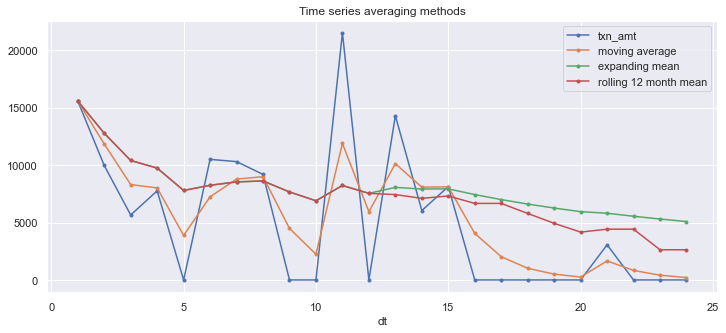

In [31]:
chid = 10055200
shop_tag = 2
im = matrix.query(f"chid=={chid} & shop_tag=={shop_tag}")[
    ['dt', 'txn_amt']]
im['moving average'] = im['txn_amt'].ewm(halflife=1).mean()
im['expanding mean'] = im['txn_amt'].expanding().mean()
im['rolling 12 month mean'] = im['txn_amt'].rolling(
    window=12, min_periods=1).mean()
im = im.set_index('dt')
ax = im.plot(figsize=(12, 5), marker='.',
             title='Time series averaging methods')


In [61]:
def add_rolling_stats(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="txn_amt",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        matrix,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="txn_amt",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # Calculate a statistic on a windowed section of a source table,  grouping on specific features
        store = []
        for i in range(2 + lag_offset, 25 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.dt.isin(
                        range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.dt.isin(
                            range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["dt"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["dt"], how="left")
        return matrix

    """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
    treated as zeroes. Creating a pivot_table fills in the zeros."""
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(
            index=features + ["dt"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).dt.min().rename("firsts")
            source = source.merge(
                firsts, left_on=g, right_index=True, how="left")
            # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
            source.loc[
                source.index.get_level_values(
                    "dt") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        # source[feat_name] = (
        #     source.groupby(features)[argfeat]
        #     .ewm(halflife=window, min_periods=1)
        #     .agg(rolling_aggfunc)
        #     .to_numpy(dtype=dtype)
        # )
        source[feat_name] = (
                source.groupby(features)[argfeat].apply(lambda x: x.ewm(halflife=window, min_periods=1).mean()).to_numpy(dtype=dtype)
            )
        del source[argfeat]
        #         source = source.reset_index()
        source["dt"] += 1 - lag_offset
        return matrix.merge(source, on=["dt"] + features, how="left")


In [62]:
matrix = op.matrix.copy()

In [49]:
features=["chid", "shop_tag"]
argfeat="txn_amt"
aggfunc="mean"
rolling_aggfunc="mean"
dtype="float16"
kind="ewm"
window=12

In [56]:
source = matrix.pivot_table(
    index=features + ["dt"],
    values=argfeat,
    aggfunc=aggfunc,
    fill_value=0,
    dropna=False,
).astype(dtype)
for g in features:
    firsts = matrix.groupby(g).dt.min().rename("firsts")
    source = source.merge(
        firsts, left_on=g, right_index=True, how="left")
    # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
    source.loc[
        source.index.get_level_values(
            "dt") < source["firsts"], argfeat
    ] = float("nan")
    del source["firsts"]

In [58]:
source = source.reset_index()

In [59]:
source

,chid,shop_tag,dt,txn_amt
0,10000229,2,1,0.0
1,10000229,2,2,0.0
2,10000229,2,3,0.0
3,10000229,2,4,0.0
4,10000229,2,5,0.0
...,...,...,...,...
383995,10499107,48,20,0.0
383996,10499107,48,21,0.0
383997,10499107,48,22,7680.0
383998,10499107,48,23,1085.0


In [28]:
features

['chid', 'shop_tag']

In [27]:
source

,chid,shop_tag,dt,txn_amt
0,10000229,2,1,0.0
1,10000229,2,2,0.0
2,10000229,2,3,0.0
3,10000229,2,4,0.0
4,10000229,2,5,0.0
...,...,...,...,...
383995,10499107,48,20,0.0
383996,10499107,48,21,0.0
383997,10499107,48,22,7680.0
383998,10499107,48,23,1085.0


In [37]:
import pandas

In [38]:
pandas.__version__

'1.1.5'

In [45]:
source['txn_amt'].ewm(halflife=1, min_periods=1)

ExponentialMovingWindow [com=1.0,min_periods=1,adjust=True,ignore_na=False,axis=0]

In [50]:
feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"

In [51]:
dtype="float16"

In [60]:
source[feat_name] = (
                source.groupby(features)[argfeat].apply(lambda x: x.ewm(halflife=window, min_periods=1).mean()).to_numpy(dtype=dtype)
            )

In [54]:
del source[argfeat]

In [55]:
source

,chid,shop_tag,dt,chid_shop_tag_txn_amt_mean_ewm_hl_12
0,10000229,2,1,0.0
1,10000229,2,2,0.0
2,10000229,2,3,0.0
3,10000229,2,4,0.0
4,10000229,2,5,0.0
...,...,...,...,...
383995,10499107,48,20,0.0
383996,10499107,48,21,0.0
383997,10499107,48,22,599.0
383998,10499107,48,23,636.5


In [46]:
source.groupby(features)['txn_amt'].apply(lambda x: x.ewm(halflife=1, min_periods=1).mean())

0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
             ...     
383995       0.000000
383996       0.000000
383997    3840.000916
383998    2462.500294
383999    4971.250296
Name: txn_amt, Length: 384000, dtype: float64

In [48]:
source.groupby(features)[argfeat].apply(lambda x: x.ewm(halflife=1, min_periods=1).mean()).to_numpy(dtype=dtype)

array([   0.,    0.,    0., ..., 3840., 2462., 4972.], dtype=float16)

In [63]:
# matrix = add_rolling_stats(
#     matrix,
#     ["chid", "shop_tag"],
#     window=12,
#     kind="rolling",
#     reshape_source=False,
# )
# matrix = add_rolling_stats(
#     matrix,
#     ["chid", "shop_tag"],
#     kind="expanding",
#     reshape_source=False,
# )
matrix = add_rolling_stats(
    matrix,
    ["chid", "shop_tag"],
    window=1,
    kind="ewm",
)

Creating feature "chid_shop_tag_txn_amt_mean_ewm_hl_1"


In [ ]:
matrix = add_rolling_stats(
    matrix,
    ["age", "shop_tag"],
    window=12,
    kind="rolling",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["age", "shop_tag"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["age", "shop_tag"],
    window=1,
    kind="ewm",
)

matrix = add_rolling_stats(
    matrix,
    ["age", "gender_code", "shop_tag"],
    window=12,
    kind="rolling",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["age", "gender_code", "shop_tag"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["age", "gender_code", "shop_tag"],
    window=1,
    kind="ewm",
)


In [51]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
gc.collect()

25

In [53]:
matrix.info(memory_usage="deep")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3840000 entries, 0 to 3839999
Data columns (total 68 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   dt                                              int8   
 1   chid                                            int32  
 2   shop_tag                                        int8   
 3   txn_cnt                                         int16  
 4   txn_amt                                         float32
 5   domestic_offline_cnt                            int16  
 6   domestic_online_cnt                             int8   
 7   overseas_offline_cnt                            int8   
 8   overseas_online_cnt                             int16  
 9   domestic_offline_amt_pct                        float32
 10  domestic_online_amt_pct                         float32
 11  overseas_offline_amt_pct                        float32
 12  overseas_online_amt_pct     